In [2]:
import network
import data
import solver

import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def gram_schmidt(N, K):
    """
    Given the dimension space dimension N, generate K random vectors and its orthogonal spans
    """
    
    def proj(u,v):
        """
        Return projection of v to u
        """
        return np.dot(v,u)/np.dot(u,u) * u
    
    V=np.random.normal(loc = 0., scale = 1, size = (K, N))
    U=np.zeros_like(V)
    
    ## Initialise u1 to v1
    U[0] = V[0]
    
    ## Gram-schomidt process
    for k in range(1,K):
        projection_terms = [proj(U[i], V[k]) for i in range(k)]
        U[k] = V[k] - np.sum(projection_terms, axis=0)
    
    return V, U
        

def control_VS(VT, angle):
    dim = len(VT)
    VT_norm = VT/np.linalg.norm(VT)
    c = np.cos(angle)
    a = np.random.normal(loc = 0., scale = .001, size = (dim))
    b = np.random.normal(loc = 0., scale = .001, size = (dim))
    h = (b-a) - np.dot((b-a),VT_norm)*VT_norm
    v = np.cos(angle)*VT_norm + np.sin(angle)*h/np.linalg.norm(h)
    
    return v*0.0001

In [15]:
def initialize_nets():
    D = 1000

    teacher1 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)
    teacher2 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)
    teacher3 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)
    teacher4 = network.ContinuousTeacher(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', standardize=True, normalize = True)

    teacher_c = network.ContextTeacher(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign')

    student1 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)
    student2 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)
    student3 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)
    student4 = network.ContinuousStudent(input_dimension = D, hidden_dimensions = [1], nonlinearity = 'sign', normalize = True)

    student_c = network.ContextStudent(input_dimension = 4, hidden_dimensions = [1], nonlinearity = 'sign')
    
    return [teacher1, teacher2, teacher3, teacher4], [student1, student2, student3, student4], teacher_c, student_c

In [16]:
dataloader_nonid = data.iid.TransientRLTask(batch_size = 1, seq_len = [2,2,2,2], input_dim = 1000, identical = False)

In [17]:
teachers, students, teacher_cs, student_cs = initialize_nets()
_, students_base, _, student_cs_base = initialize_nets()


In [10]:
import torch

In [28]:
curriculum_solver=solver.TwoPhaseContextTSSolver(teachers=teachers, \
                                               students = students, context_teachers=teacher_cs, \
                                               context_students=student_cs, dataloaders = [dataloader_nonid, dataloader_nonid, dataloader_nonid], logdir = None, identical = False)


TypeError: TwoPhaseContextTSSolver.__init__() missing 2 required keyword-only arguments: 'context_teacher' and 'context_student'

In [19]:
curriculum_solver.train(nums_iter = [20000,20000], lrs = [(10,1),(1,0.1)], update_frequency=100)

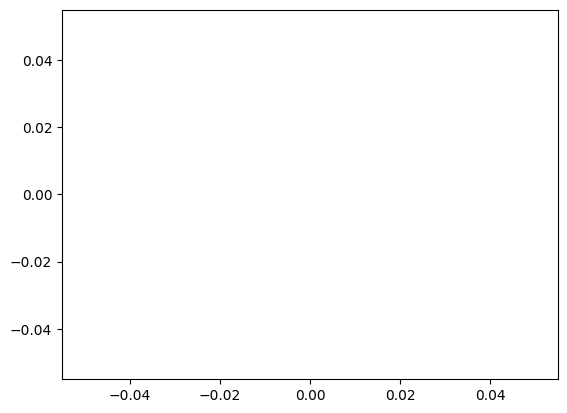

In [22]:
plt.plot(curriculum_solver.history['phase2']['empirical_P_tilde'])

In [21]:
curriculum_solver.history['phase2'].keys()

dict_keys(['R', 'Q', 'P', 'P_tilde', 'empirical_P_tilde', 'VS', 'VT'])

In [26]:
curriculum_solver.history['phase2'].keys()

dict_keys(['R', 'Q', 'P', 'P_tilde', 'empirical_P_tilde', 'VS', 'VT'])

In [27]:
base_solver = solver.TwoPhaseContextSolver(teachers = teachers, \
                                          students = students_base, context_teacher = teacher_cs, 
                                          context_student = student_cs_base, dataloaders = [dataloader_id, dataloader_id, dataloader_id], logdir = None)

In [98]:
base_solver.train(nums_iter =[0, 40000], lrs = [(10,1),(10,0.01)], update_frequency = 100)

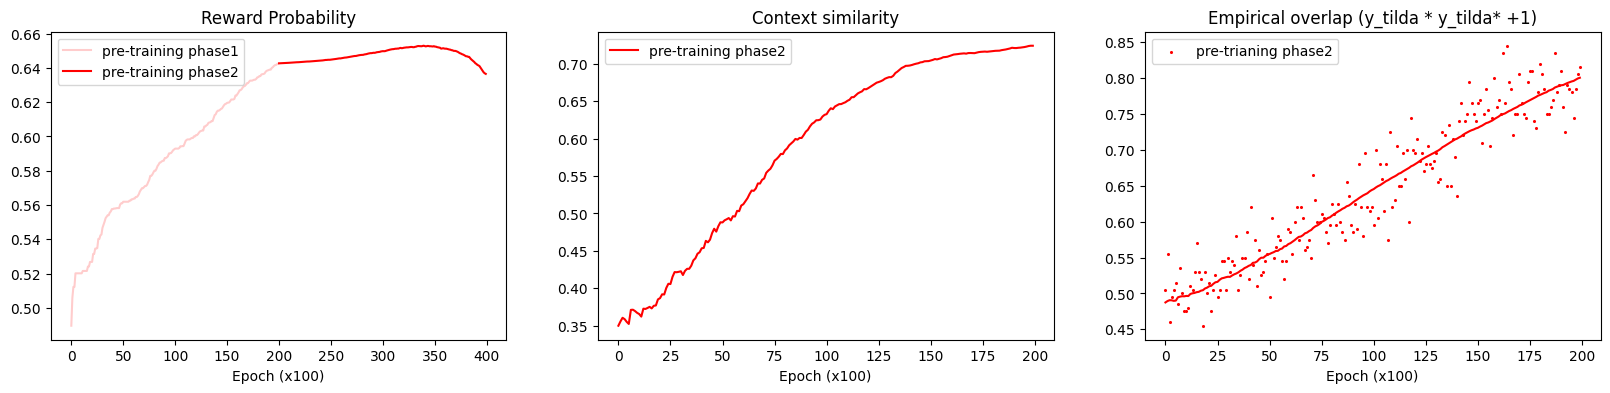

In [35]:
base = False
curriculum = True
fig = plt.figure(figsize=(20, 4))
ax1 = plt.subplot(131)
if curriculum:
    ax1.plot(np.power(curriculum_solver.history['phase1']['reward_rate'], 1/8), label = 'pre-training phase1', c= 'r', alpha = 0.2)
    len_phase1 = len(curriculum_solver.history['phase1']['reward_rate'])
    len_phase2 = len(curriculum_solver.history['phase2']['reward_rate'])
    ax1.plot(np.arange(len_phase1, len_phase1+len_phase2),
             np.power(curriculum_solver.history['phase2']['reward_rate'],1/8), label = 'pre-training phase2', c= 'r')
if base:
    ax1.plot(np.power(base_solver.history['phase2']['reward_rate'], 1/8), label = 'baseline', c= 'gray')
ax1.set_title('Reward Probability')
ax1.set_xlabel('Epoch (x100)')

plt.legend()
ax2 = plt.subplot(132)
if curriculum:
    ax2.plot(curriculum_solver.history['phase2']['context_similarity'], label = 'pre-training phase2', c = 'r')
if base:
    ax2.plot(base_solver.history['phase2']['context_similarity'], label = 'baseline', c= 'gray')
ax2.set_title('Context similarity')
ax2.set_xlabel('Epoch (x100)')
plt.legend()

ax3 = plt.subplot(133)

if curriculum:
    curriculum_empirical_overlap = curriculum_solver.history['phase2']['overlap']
    curriculum_P = curriculum_solver.history['phase2']['P_tot']
    ax3.scatter(np.arange(len(curriculum_empirical_overlap)),curriculum_empirical_overlap, s= 1.5, c = 'r', label = 'pre-trianing phase2')
    ax3.plot(np.power(np.array(curriculum_P),1),  c = 'r', )
if base:
    base_empirical_overlap = base_solver.history['phase2']['overlap']
    base_P = base_solver.history['phase2']['P']
    ax3.scatter(np.arange(len(base_empirical_overlap)),base_empirical_overlap, c= 'gray', label = 'baseline', s=1.5)
    ax3.plot(np.power(np.array(base_P),2)+1, c= 'gray', )

ax3.set_title('Empirical overlap (y_tilda * y_tilda* +1)')
ax3.set_xlabel('Epoch (x100)')
plt.legend()

In [21]:
np.power(0.35, 1/8)

0.8770179971434217